## Find restaurants near a business hub for site suitability in Chicago

In [1]:
from pyplaces import overture_maps as om
import folium

In [2]:
import geopandas as gpd
import pandas as pd
def plot_geodataframes(gdfs, zoom_start=14, popup_columns=None):
    if not isinstance(gdfs, list):
        gdfs = [gdfs]
    if popup_columns is None:
        popup_columns = [None] * len(gdfs)

    # Filter out empty GeoDataFrames
    gdfs_filtered = [(gdf, popup_columns[i]) for i, gdf in enumerate(gdfs) if not gdf.empty]

    if not gdfs_filtered:
        print("All GeoDataFrames are empty.")
        return None

    # Center the map at the centroid of the first non-empty GeoDataFrame
    all_geoms = gpd.GeoSeries(pd.concat([gdf.geometry for gdf, _ in gdfs_filtered], ignore_index=True))
    center = all_geoms.union_all().centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=zoom_start, tiles="CartoDB positron")

    for gdf, popup_col in gdfs_filtered:
        # Check if all geometries are Points
        if gdf.geometry.geom_type.isin(['Point']).all():
            for _, row in gdf.iterrows():
                coords = [row.geometry.y, row.geometry.x]
                popup = str(row[popup_col]) if popup_col and popup_col in row else None
                folium.CircleMarker(
                    location=coords,
                    radius=1,   # size of the dot
                    color='green',
                    fill=True,
                    fill_color='green',
                    fill_opacity=1,
                    popup=popup
                ).add_to(m)
        else:
            # Otherwise treat as polygon or line geometries
            if popup_col and popup_col in gdf.columns:
                folium.GeoJson(
                    gdf,
                    tooltip=folium.GeoJsonTooltip(fields=[popup_col], aliases=['Name:']),
                    popup=folium.GeoJsonPopup(fields=[popup_col])
                ).add_to(m)
            else:
                folium.GeoJson(gdf).add_to(m)

    return m

In [3]:
# Get all restaurants in the Near West Side
gdf_food = om.overture_places_from_place("Near West Side, Chicago, IL",filters=[("categories.primary","contains","restaurant")])

# Filter buildings by height
gdf_buildings = om.overture_buildings_from_place(
    address="Near West Side, Chicago, IL",
    filters=[("num_floors", ">=", 5)]
)

# put primary name of place into "name"
gdf_food["name"] = gdf_food["names"].apply(lambda x: x["primary"])

In [10]:
gdf_food.head(5)

,id,geometry,bbox,version,sources,names,categories,confidence,websites,socials,emails,phones,brand,addresses,name
3,08f2664cab32432a039d3a31a79f59d7,POINT (-87.68687 41.86291),"{'xmin': -87.68687438964844, 'xmax': -87.68685...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'El Ideas', 'common': None, 'rules...","{'primary': 'american_restaurant', 'alternate'...",0.978172,[http://www.elideas.com/],[https://www.facebook.com/209428082411028],None,[+13122268144],None,"[{'freeform': '2419 W 14th St', 'locality': 'C...",El Ideas
4,08f2664caba812d4031aedbaee003b01,POINT (-87.68645 41.86409),"{'xmin': -87.68645477294922, 'xmax': -87.68643...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'Burger King', 'common': None, 'ru...","{'primary': 'fast_food_restaurant', 'alternate...",0.994980,[https://burgerking.com/store-locator/store/re...,[https://www.facebook.com/895628703864497],None,[+13122435293],"{'wikidata': None, 'names': {'primary': 'Burge...","[{'freeform': '2401 W Ogden Ave', 'locality': ...",Burger King
5,08f2664caba3274c03df8f43e1d7c6d3,POINT (-87.68414 41.86549),"{'xmin': -87.68415069580078, 'xmax': -87.68414...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'McDonald's', 'common': None, 'rul...","{'primary': 'fast_food_restaurant', 'alternate...",0.994980,[https://www.mcdonalds.com/us/en-us/location/i...,[https://www.facebook.com/372215050276943],None,[+13127337712],"{'wikidata': None, 'names': {'primary': 'McDon...","[{'freeform': '2315 W Ogden Ave', 'locality': ...",McDonald's
6,08f2664cabb9c14d030d1bee6d321c3f,POINT (-87.68631 41.86711),"{'xmin': -87.68630981445312, 'xmax': -87.68629...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'KFC', 'common': None, 'rules': None}","{'primary': 'fast_food_restaurant', 'alternate...",0.994980,[https://locations.kfc.com/il/chicago/1144-s-w...,[https://www.facebook.com/176694659151249],None,[+13126009353],"{'wikidata': None, 'names': {'primary': 'KFC',...","[{'freeform': '1144 S Western Ave', 'locality'...",KFC
7,08f2664cabb8840503bf06ffa2d6f115,POINT (-87.6852 41.86647),"{'xmin': -87.6852035522461, 'xmax': -87.685195...",0,"[{'property': '', 'dataset': 'meta', 'record_i...","{'primary': 'The Dopest Bar and Grill', 'commo...","{'primary': 'bar_and_grill_restaurant', 'alter...",0.978172,[http://www.thedopestbar.com],[https://www.facebook.com/104856918532349],None,[+13122919297],None,"[{'freeform': '2343 W Roosevelt Rd', 'locality...",The Dopest Bar and Grill


In [11]:
gdf_food[["id","geometry",'name']].head(1)

,id,geometry,name
3,08f2664cab32432a039d3a31a79f59d7,POINT (-87.68687 41.86291),El Ideas


In [12]:
gdf_buildings[["id","subtype","geometry"]].head(1)

,id,subtype,geometry
1,08b2664caba0cfff0200e24d7de9b351,None,"POLYGON ((-87.6822 41.86477, -87.68219 41.8644..."


In [8]:
m = plot_geodataframes([gdf_food[["id","geometry",'name']],gdf_buildings[["id","subtype","geometry"]],],popup_columns=["name","subtype"])
m

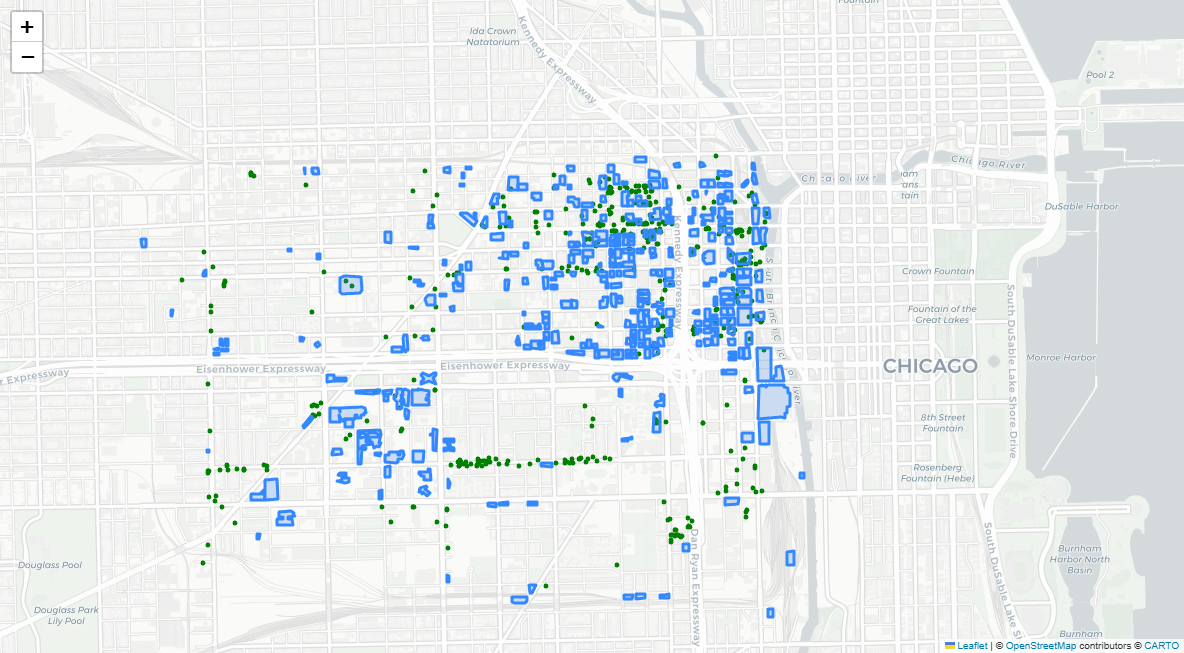

In [9]:
# Final cell to add to your notebook that will output a PNG of your Folium map

# First, save your map to an HTML file
map_html = 'temp_map.html'
m.save(map_html)  # Replace 'my_map' with your actual map variable name

# Use Selenium to convert the map to a PNG image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import os
from IPython.display import Image

# Configure Chrome in headless mode
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--window-size=1200,800")  # Adjust size as needed
driver = webdriver.Chrome(options=chrome_options)

# Load the HTML file
driver.get(f'file://{os.path.abspath(map_html)}')
time.sleep(2)  # Allow the map to fully render

# Take the screenshot
thumbnail_path = 'map_thumbnail4.png'
driver.save_screenshot(thumbnail_path)
driver.quit()

# Clean up the temporary HTML file
os.remove(map_html)

# Display the image - this will be the cell output that Sphinx can use
Image(filename=thumbnail_path)